In [ ]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/dataset/dataset/'
classes = os.listdir(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

In [ ]:
dataset = ImageFolder(data_dir, transform=train_transform)
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
#We do not change the accuracy method to ensure we can compare with baseline model
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)
#This is where we define the loss function,the baseline use cross entropy，we won't change it since CE is a good loss function
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, (5))
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*112*112
output_size = 151

In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x)

class Stem(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Stem, self).__init__()
        #conv3*3(32 stride2 valid)
        self.conv1 = BasicConv2d(in_channels, 32, kernel_size=3, stride=2)
        #conv3*3(32 valid)
        self.conv2 = BasicConv2d(32, 32, kernel_size=3)
        #conv3*3(64)
        self.conv3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        #maxpool3*3(stride2 valid) & conv3*3(96 stride2 valid)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv4 = BasicConv2d(64, 96, kernel_size=3, stride=2)

        #conv1*1(64) --> conv3*3(96 valid)
        self.conv5_1_1 = BasicConv2d(160, 64, kernel_size=1)
        self.conv5_1_2 = BasicConv2d(64, 96, kernel_size=3)
        #conv1*1(64) --> conv7*1(64) --> conv1*7(64) --> conv3*3(96 valid)
        self.conv5_2_1 = BasicConv2d(160, 64, kernel_size=1)
        self.conv5_2_2 = BasicConv2d(64, 64, kernel_size=(7,1), padding=(3,0))
        self.conv5_2_3 = BasicConv2d(64, 64, kernel_size=(1,7), padding=(0,3))
        self.conv5_2_4 = BasicConv2d(64, 96, kernel_size=3)

        #conv3*3(192 valid)
        self.conv6 = BasicConv2d(192, 192, kernel_size=3, stride=2)
        #maxpool3*3(stride2 valid)
        self.maxpool6 = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        y1_1 = self.maxpool4(self.conv3(self.conv2(self.conv1(x))))
        y1_2 = self.conv4(self.conv3(self.conv2(self.conv1(x))))
        y1 = torch.cat([y1_1, y1_2], 1)

        y2_1 = self.conv5_1_2(self.conv5_1_1(y1))
        y2_2 = self.conv5_2_4(self.conv5_2_3(self.conv5_2_2(self.conv5_2_1(y1))))
        y2 = torch.cat([y2_1, y2_2], 1)

        y3_1 = self.conv6(y2)
        y3_2 = self.maxpool6(y2)
        y3 = torch.cat([y3_1, y3_2], 1)

        return y3

In [ ]:
class InceptionA(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionA, self).__init__()
        #branch1: avgpool --> conv1*1(96)
        self.b1_1 = nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        self.b1_2 = BasicConv2d(in_channels, 96, kernel_size=1)

        #branch2: conv1*1(96)
        self.b2 = BasicConv2d(in_channels, 96, kernel_size=1)

        #branch3: conv1*1(64) --> conv3*3(96)
        self.b3_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.b3_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)

        #branch4: conv1*1(64) --> conv3*3(96) --> conv3*3(96)
        self.b4_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.b4_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)

    def forward(self, x):
        y1 = self.b1_2(self.b1_1(x))
        y2 = self.b2(x)
        y3 = self.b3_2(self.b3_1(x))
        y4 = self.b4_2(self.b4_1(x))

        outputsA = [y1, y2, y3, y4]
        return torch.cat(outputsA, 1)

In [ ]:
class ReductionA(nn.Module):
    def __init__(self, in_channels, out_channels, k, l, m, n):
        super(ReductionA, self).__init__()
        #branch1: maxpool3*3(stride2 valid)
        self.b1 = nn.MaxPool2d(kernel_size=3, stride=2)

        #branch2: conv3*3(n stride2 valid)
        self.b2 = BasicConv2d(in_channels, n, kernel_size=3, stride=2)

        #branch3: conv1*1(k) --> conv3*3(l) --> conv3*3(m stride2 valid)
        self.b3_1 = BasicConv2d(in_channels, k, kernel_size=1)
        self.b3_2 = BasicConv2d(k, l, kernel_size=3, padding=1)
        self.b3_3 = BasicConv2d(l, m, kernel_size=3, stride=2)

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3_3(self.b3_2(self.b3_1(x)))

        outputsRedA = [y1, y2, y3]
        return torch.cat(outputsRedA, 1)

In [ ]:
class Googlenetv4(ImageClassificationBase):
    def __init__(self, classes):
        super(Googlenetv4, self).__init__()
        self.num_classes=classes
        self.stem = Stem(3, 384)
        self.icpA = InceptionA(384, 384)
        self.redA = ReductionA(384, 1024, 192, 224, 256, 384)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.8)
        self.linear = nn.Linear(4096,num_classes)

    def forward(self, x):
        #Stem Module
        out = self.stem(x)
        #InceptionA Module
        out = self.icpA(out)
        #ReductionA Module
        out = self.redA(out)
        #Average Pooling
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        #Dropout
        out = self.dropout(out)
        #Linear(Softmax)
        out = self.linear(out)
        return out

In [ ]:
num_classes = 151
model = Googlenetv4(num_classes)
model.cuda()

Googlenetv4(
  (stem): Stem(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): BasicConv2d(
      (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2))
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv5_1_1): BasicConv2d(
      (conv): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchN

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

Googlenetv4(
  (stem): Stem(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): BasicConv2d(
      (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2))
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv5_1_1): BasicConv2d(
      (conv): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchN

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(model, device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.017206192016602, 'val_acc': 0.01875000074505806}]

In [ ]:
num_epochs = 40
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.6438, val_loss: 4.8005, val_acc: 0.0556


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.8209, val_loss: 4.5919, val_acc: 0.1080


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.5866, val_loss: 4.4041, val_acc: 0.1274


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.4175, val_loss: 4.2828, val_acc: 0.1809


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.2629, val_loss: 4.1448, val_acc: 0.2010


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.1244, val_loss: 3.9109, val_acc: 0.2503


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.9859, val_loss: 3.7638, val_acc: 0.3264


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.9107, val_loss: 3.8456, val_acc: 0.2872


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.7663, val_loss: 3.6010, val_acc: 0.2934


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.6469, val_loss: 3.5362, val_acc: 0.3340


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.4930, val_loss: 3.4328, val_acc: 0.3670


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.4400, val_loss: 3.3311, val_acc: 0.3858


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 3.3273, val_loss: 3.2622, val_acc: 0.4139


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 3.2219, val_loss: 3.2357, val_acc: 0.4069


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 3.1425, val_loss: 3.1001, val_acc: 0.4302


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 3.0443, val_loss: 3.1458, val_acc: 0.4497


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 2.9514, val_loss: 2.9544, val_acc: 0.4590


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 2.9000, val_loss: 3.0125, val_acc: 0.4958


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 2.8315, val_loss: 3.0327, val_acc: 0.4358


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 2.7421, val_loss: 2.9538, val_acc: 0.4965


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 2.6725, val_loss: 2.9686, val_acc: 0.4670


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 2.5935, val_loss: 2.8537, val_acc: 0.4927


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 2.5426, val_loss: 2.8060, val_acc: 0.4958


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 2.5162, val_loss: 2.7619, val_acc: 0.5351


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 2.4216, val_loss: 2.7063, val_acc: 0.5226


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 2.3736, val_loss: 2.7975, val_acc: 0.5257


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 2.2761, val_loss: 2.5707, val_acc: 0.5757


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 2.2323, val_loss: 2.7746, val_acc: 0.5146


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 2.1678, val_loss: 2.6681, val_acc: 0.5507


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 2.0948, val_loss: 2.6912, val_acc: 0.5483


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [30], train_loss: 2.0476, val_loss: 2.5657, val_acc: 0.5694


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [31], train_loss: 2.0584, val_loss: 2.8417, val_acc: 0.5389


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [32], train_loss: 2.2907, val_loss: 2.6697, val_acc: 0.5851


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [33], train_loss: 2.0878, val_loss: 2.6118, val_acc: 0.5788


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [34], train_loss: 1.9365, val_loss: 2.5302, val_acc: 0.5851


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [35], train_loss: 1.8237, val_loss: 2.4816, val_acc: 0.5896


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [36], train_loss: 1.7873, val_loss: 2.5176, val_acc: 0.5851


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [37], train_loss: 1.7383, val_loss: 2.6289, val_acc: 0.5663


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [38], train_loss: 1.6927, val_loss: 2.4433, val_acc: 0.5795


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [39], train_loss: 1.6399, val_loss: 2.5074, val_acc: 0.6125


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

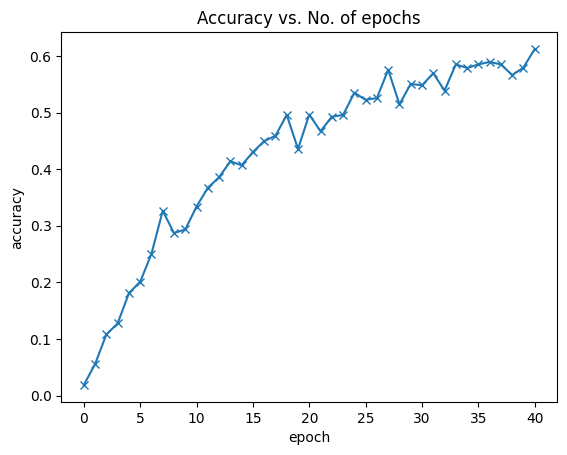

In [ ]:
plot_accuracies(history)

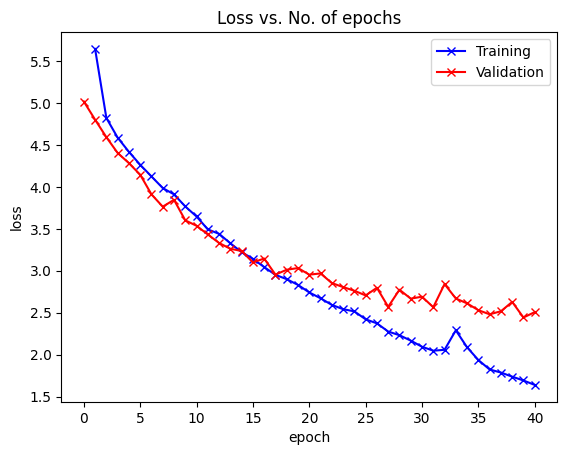

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 2.3675217628479004, 'val_acc': 0.6744791865348816}

In [ ]:
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py

--2023-08-03 09:39:52--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=h86dqstbgh92nmuba1javv04vs; path=/plus; domain=.aarnet.edu.au;; Secure; SameSite=Lax at position 76.
Syntax error in Set-Cookie: oc_sessionPassphrase=3i8WTZKU0yZWevfvD8OztLkWWcPcd%2FUeyunCWhe5MpQBeDd6RRtB94ob2P6O5pX2452UhAg5FpWniYp5a%2Fv2Ju%2FhHUfOPWhrkEpDkefPN%2BE16OP06kOB7HF6p1arFMd2; expires=Fri, 04-Aug-2023 09:39:52 GMT; Max-Age=86400; path=/plus;; Secure; SameSite=Lax at position 224.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2023-08-03 09:39:53 (2.33 GB/s) - ‘download’ saved [5201/5201]



In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = Googlenetv4(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.97G
